# ДЗ №5 Сегментация
Реализация сети для сегметации объектов.

__Задача__ сделать работоспособную сеть для сегментирования изображений авто на основе предложенного шаблона


![Segmentation](img/Segment04.png)

### Что делаем
Реализуем сверточную сеть для семантической сегментации, downsample->upsample -> Классификация каждого пикселя выходного изображения: 0 - не авто, 1 - авто. Выход картинка с x каналами, для классификации.
1. В файле model.py   - имплементировать модель вместо заглушки
2. В файле train.py - поставить правильный loss

### Данные
[Carvana](https://cloud.mail.ru/public/3tdq/AvtaHkDAb)

### Зависимости
 - tensorflow  - поддержка tensorboard
 - tensorboardx - тензор боард для pytorch
 - tqdm         - пакет для отрисовки прогресс баров

### Запуск пакета
_ По умолчанию все данные лежат в папке ./data/. Если вы положили их в другую папку, то поправте в скрипте train.py пути _
<br/>
Запускаем обучение сети
python train.py

Результаты обучение можно наблюдать в tensorboard

Запуск tensorboard --log ./od_log

## Результаты
1. Код model.py, train.py
2. Модель state_dicts()

### Тут нужно сделать загрузку состояния вашей модели, код модели в ноутбук тащить не нужно, достаточно сделать import model


In [21]:
import torch.utils.data as dt
from torch.autograd import Variable
import torch
from carvana_dataset import CarvanaDataset
from model import SegmenterModel, BCECriterion
from tqdm import tqdm_notebook as tqdm

test = './data/test/'
test_masks = './data/test_masks'
useCuda = True

In [22]:
criterion = BCECriterion()

In [23]:
model = SegmenterModel()
model.load_state_dict(torch.load('state_dict.pth'))
model = model.cuda()
model.train(False)

SegmenterModel(
  (high_res_down): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
  )
  (med_res_down): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (2): Sequential(
      (0): Conv2d(3

In [24]:
ds_test = CarvanaDataset(test, test_masks)
dl_test = dt.DataLoader(ds_test, shuffle=False, num_workers=4, batch_size=5)

In [25]:
print("Make test")
test_loss = 0
model.train(False)

for iter, (i, t) in enumerate(tqdm(dl_test)):
    i = Variable(i, volatile = True)
    t = Variable(t, volatile = True)
    if useCuda :
        i = i.cuda()
        t = t.cuda()
    o = model(i)
    loss = criterion(o, t)
    test_loss += loss.data.item()

test_loss = test_loss / float(len(ds_test))
print("Test loss", test_loss)

Make test


/home/tsanda.ap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/home/tsanda.ap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys



Test loss 0.00439534524792996


### Тут нужно нарисовать картинки, с результатими сегментации из тестового сета

In [26]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

In [27]:
from IPython import display

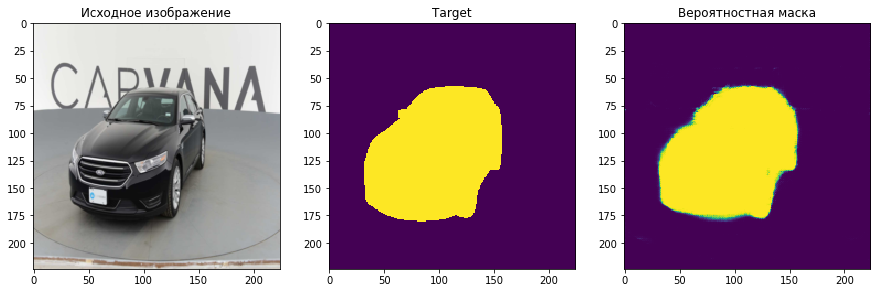

In [30]:
show_mask(42)

In [29]:
@interact(i=IntSlider(min=0, max=len(dl_test), step=1, value=10, continuous_update=False))
def show_mask(i):
    input, target = ds_test[i]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(input.detach().numpy().transpose(1, 2, 0))
    ax1.set_title('Исходное изображение')
    ax2.imshow(target.detach().numpy()[0])
    ax2.set_title('Target')
    
    with torch.no_grad():
        inp = torch.unsqueeze(input, 0)
        output = model.forward(inp.cuda())
        output = output.cpu().detach().numpy()
        ax3.imshow(output[0, 0])
    ax3.set_title('Вероятностная маска')

interactive(children=(IntSlider(value=10, continuous_update=False, description='i', max=102), Output()), _dom_…